<a href="https://colab.research.google.com/github/1aaronscott/DS-Unit-2-Kaggle-Challenge/blob/master/module1/261_assignment_kaggle_challenge_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science, Unit 2: Predictive Modeling

# Kaggle Challenge, Module 1

## Assignment
- [x] Do train/validate/test split with the Tanzania Waterpumps data.
- [x] Define a function to wrangle train, validate, and test sets in the same way. Clean outliers and engineer features. (For example, [what other columns have zeros and shouldn't?](https://github.com/Quartz/bad-data-guide#zeros-replace-missing-values) What other columns are duplicates, or nearly duplicates? Can you extract the year from date_recorded? Can you engineer new features, such as the number of years from waterpump construction to waterpump inspection?)
- [x] Select features. Use a scikit-learn pipeline to encode categoricals, impute missing values, and fit a decision tree classifier.
- [x] Get your validation accuracy score.
- [x] Get and plot your feature importances.
- [x] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [x] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

### Reading

- A Visual Introduction to Machine Learning
  - [Part 1: A Decision Tree](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/)
  - [Part 2: Bias and Variance](http://www.r2d3.us/visual-intro-to-machine-learning-part-2/)
- [Decision Trees: Advantages & Disadvantages](https://christophm.github.io/interpretable-ml-book/tree.html#advantages-2)
- [How a Russian mathematician constructed a decision tree — by hand — to solve a medical problem](http://fastml.com/how-a-russian-mathematician-constructed-a-decision-tree-by-hand-to-solve-a-medical-problem/)
- [How decision trees work](https://brohrer.github.io/how_decision_trees_work.html)
- [Let’s Write a Decision Tree Classifier from Scratch](https://www.youtube.com/watch?v=LDRbO9a6XPU) — _Don’t worry about understanding the code, just get introduced to the concepts. This 10 minute video has excellent diagrams and explanations._
- [Random Forests for Complete Beginners: The definitive guide to Random Forests and Decision Trees](https://victorzhou.com/blog/intro-to-random-forests/)


### Doing
- [ ] Add your own stretch goal(s) !
- [ ] Try other [scikit-learn imputers](https://scikit-learn.org/stable/modules/impute.html).
- [ ] Try other [scikit-learn scalers](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Make exploratory visualizations and share on Slack.


#### Exploratory visualizations

Visualize the relationships between feature(s) and target. I recommend you do this with your training set, after splitting your data. 

For this problem, you may want to create a new column to represent the target as a number, 0 or 1. For example:

```python
train['functional'] = (train['status_group']=='functional').astype(int)
```



You can try [Seaborn "Categorical estimate" plots](https://seaborn.pydata.org/tutorial/categorical.html) for features with reasonably few unique values. (With too many unique values, the plot is unreadable.)

- Categorical features. (If there are too many unique values, you can replace less frequent values with "OTHER.")
- Numeric features. (If there are too many unique values, you can [bin with pandas cut / qcut functions](https://pandas.pydata.org/pandas-docs/stable/getting_started/basics.html?highlight=qcut#discretization-and-quantiling).)

You can try [Seaborn linear model plots](https://seaborn.pydata.org/tutorial/regression.html) with numeric features. For this problem, you may want to use the parameter `logistic=True`

You do _not_ need to use Seaborn, but it's nice because it includes confidence intervals to visualize uncertainty.

#### High-cardinality categoricals

This code from a previous assignment demonstrates how to replace less frequent values with 'OTHER'

```python
# Reduce cardinality for NEIGHBORHOOD feature ...

# Get a list of the top 10 neighborhoods
top10 = train['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10,
# replace the neighborhood with 'OTHER'
train.loc[~train['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
test.loc[~test['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
```



In [0]:
# If you're in Colab...
import os, sys
in_colab = 'google.colab' in sys.modules

if in_colab:
    # Install required python packages:
    # category_encoders, version >= 2.0
    # pandas-profiling, version >= 2.0
    # plotly, version >= 4.0
    !pip install --upgrade category_encoders pandas-profiling plotly
    
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge.git
    !git pull origin master
    
    # Change into directory for module
    os.chdir('module1')

In [68]:
import pandas as pd
from sklearn.model_selection import train_test_split

train = pd.merge(pd.read_csv('../data/tanzania/train_features.csv', parse_dates=True, infer_datetime_format=True), 
                 pd.read_csv('../data/tanzania/train_labels.csv', parse_dates=True, infer_datetime_format=True))
test = pd.read_csv('../data/tanzania/test_features.csv', parse_dates=True, infer_datetime_format=True)
sample_submission = pd.read_csv('../data/tanzania/sample_submission.csv', parse_dates=True, infer_datetime_format=True)

train.shape, test.shape

((59400, 41), (14358, 40))

**Do train/validate/test split with the Tanzania Waterpumps data.**

In [69]:
train, validate = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train['status_group'], random_state=42)
train.shape, validate.shape, test.shape

((47520, 41), (11880, 41), (14358, 40))

In [43]:
validate.columns

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group', 'status_group'],
      dtype='object')

In [12]:
train.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,47520.000000,47520.000000,47520.000000,47520.000000,4.752000e+04,47520.000000,47520.000000,47520.000000,47520.000000,47520.000000
mean,37037.915699,321.925261,669.567656,34.082431,-5.705946e+00,0.477736,15.258291,5.616751,179.805513,1302.768939
std,21412.099719,3197.240487,693.005745,6.552053,2.941332e+00,13.312977,17.530228,9.621230,463.081564,950.955437
min,0.000000,0.000000,-63.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18482.750000,0.000000,0.000000,33.092142,-8.528215e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,36986.500000,0.000000,372.500000,34.910740,-5.021436e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55450.250000,25.000000,1320.000000,37.170578,-3.327185e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.344301,-2.000000e-08,1776.000000,99.000000,80.000000,15300.000000,2013.000000


In [13]:
train.describe(exclude='number')

,date_recorded,funder,installer,wpt_name,basin,subvillage,region,lga,ward,public_meeting,recorded_by,scheme_management,scheme_name,permit,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
count,47520,44616,44603,47520,47520,47234,47520,47520,47520,44876,47520,44392,24988,45077,47520,47520,47520,47520,47520,47520,47520,47520,47520,47520,47520,47520,47520,47520,47520,47520,47520
unique,349,1716,1929,30661,9,17231,21,124,2082,2,1,12,2563,2,18,13,7,12,5,7,7,8,6,5,5,10,7,3,7,6,3
top,2011-03-17,Government Of Tanzania,DWE,none,Lake Victoria,Shuleni,Iringa,Njombe,Igosi,True,GeoData Consultants Ltd,VWC,K,True,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
freq,474,7321,13978,2879,8137,420,4250,2003,257,40838,47520,29470,548,31071,21448,21448,21448,32449,42027,20287,20287,40598,40598,26567,26567,13620,13620,36638,22778,27642,25807


In [16]:
train.dtypes

id                                int64
amount_tsh                      float64
date_recorded            datetime64[ns]
funder                           object
gps_height                        int64
installer                        object
longitude                       float64
latitude                        float64
wpt_name                         object
num_private                       int64
basin                            object
subvillage                       object
region                           object
region_code                       int64
district_code                     int64
lga                              object
ward                             object
population                        int64
public_meeting                   object
recorded_by                      object
scheme_management                object
scheme_name                      object
permit                           object
construction_year                 int64
extraction_type                  object


In [0]:
train.date_recorded = pd.to_datetime(train.date_recorded)

**Define a function to wrangle train, validate, and test sets in the same way. Clean outliers and engineer features.**

In [0]:
import numpy as np

def cleaner(X):
    # stop SettingWithCopyWarning
    X = X.copy()
    
    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these values like zero.
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    
    # When columns have zeros and shouldn't, they are like null values.
    # So we will replace the zeros with nulls, and impute missing values later.
    cols_with_zeros = ['longitude', 'latitude', 'construction_year', 'district_code']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
            
    # quantity & quantity_group are duplicates, so drop one
    # X = X.drop(columns='quantity_group')
    X = X.drop(columns=['quantity_group', 'installer', 'extraction_type_group', 
                        'extraction_type_class', 'payment_type', 'waterpoint_type_group'])
    #removing columns negatively impacts validation accuracy

    #convert date_recorded to datetime
    X['date_recorded'] = pd.to_datetime(X.date_recorded)

    #create a new feature for pump_age
    X['pump_age'] = X.date_recorded.dt.year - X.construction_year
    
    # return the wrangled dataframe
    return X



possible dupe columns:
funder/installer

extraction_type/extraction_type_group/exracion_type_class

payment/payment_type

waterpoint_type/waterpoint_type_group



In [0]:
train = cleaner(train)
validate = cleaner(validate)
test = cleaner(test)

In [72]:
train.shape, validate.shape, test.shape

((47520, 36), (11880, 36), (14358, 35))

In [45]:
train.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
43360,72938,0.0,2011-07-27,NaN,0,NaN,33.542898,-9.174777,Kwa Mzee Noa,0,Lake Nyasa,Mpandapanda,Mbeya,12,4,Rungwe,Kiwira,0,True,GeoData Consultants Ltd,VWC,K,NaN,0,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,functional
7263,65358,500.0,2011-03-23,Rc Church,2049,ACRA,34.665760,-9.308548,Kwa Yasinta Ng'Ande,0,Rufiji,Kitichi,Iringa,11,4,Njombe,Imalinyi,175,True,GeoData Consultants Ltd,WUA,Tove Mtwango gravity Scheme,True,2008,gravity,gravity,gravity,wua,user-group,pay monthly,monthly,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
2486,469,25.0,2011-03-07,Donor,290,Do,38.238568,-6.179919,Kwasungwini,0,Wami / Ruvu,Kwedigongo,Pwani,6,1,Bagamoyo,Mbwewe,2300,True,GeoData Consultants Ltd,VWC,NaN,False,2010,india mark ii,india mark ii,handpump,vwc,user-group,pay per bucket,per bucket,salty,salty,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,functional
313,1298,0.0,2011-07-31,Government Of Tanzania,0,DWE,30.716727,-1.289055,Kwajovin 2,0,Lake Victoria,Kihanga,Kagera,18,1,Karagwe,Isingiro,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,other,other,other,vwc,user-group,never pay,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,other,other,non functional
52726,27001,0.0,2011-03-10,Water,0,Gove,35.389331,-6.399942,Chama,0,Internal,Mtakuj,Dodoma,1,6,Bahi,Nondwa,0,True,GeoData Consultants Ltd,VWC,Zeje,True,0,mono,mono,motorpump,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,machine dbh,borehole,groundwater,communal standpipe,communal standpipe,functional


In [37]:
train.isnull().sum()

id                           0
amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                 1812
latitude                  1812
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code               23
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year        20709
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_

**Select features. Use a scikit-learn pipeline to encode categoricals, impute missing values, and fit a decision tree classifier.**

In [73]:
#exclude the target column
target = 'status_group'

# remove target and id columns
train_features = train.drop(columns=[target, 'id'])

# list of only the numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# Get a series with the cardinality of the categorical features
cardinality = train_features.select_dtypes(exclude='number').nunique()

# all categorical features with cardinality <= 50
categorical_features = cardinality[cardinality <= 50].index.tolist()

# Combine the lists 
features = numeric_features + categorical_features
print(features)

['amount_tsh', 'gps_height', 'longitude', 'latitude', 'num_private', 'region_code', 'district_code', 'population', 'construction_year', 'pump_age', 'basin', 'region', 'public_meeting', 'recorded_by', 'scheme_management', 'permit', 'extraction_type', 'management', 'management_group', 'payment', 'water_quality', 'quality_group', 'quantity', 'source', 'source_type', 'source_class', 'waterpoint_type']


In [0]:
# Arrange data into X features matrices and y target vectors
X_train = train[features]
y_train = train[target]
X_validate = validate[features]
y_validate = validate[target]
X_test = test[features]

In [75]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier


decision_tree = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True), 
    SimpleImputer(), 
    StandardScaler(), 
    DecisionTreeClassifier(random_state=42)
)

# Fit on train
decision_tree.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['basin', 'region', 'public_meeting',
                                     'recorded_by', 'scheme_management',
                                     'permit', 'extraction_type', 'management',
                                     'management_group', 'payment',
                                     'water_quality', 'quality_group',
                                     'quantity', 'source', 'source_type',
                                     'source_class', 'waterpoint_type'],
                               drop_invariant=False, handle_missing='value',
                               hand...
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(class_weight=None, criterion='gini',
                                        max_depth=None, max_features=None,
                                        max_

**Get your validation accuracy score.**

In [76]:
print('Train Accuracy', decision_tree.score(X_train, y_train))
print('Validation Accuracy', decision_tree.score(X_validate, y_validate))

Train Accuracy 0.9954755892255892
Validation Accuracy 0.7577441077441077


**Get and plot your feature importances.**

In [52]:
decision_tree.named_steps

{'decisiontreeclassifier': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                        max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort=False,
                        random_state=42, splitter='best'),
 'onehotencoder': OneHotEncoder(cols=['basin', 'region', 'public_meeting', 'recorded_by',
                     'scheme_management', 'permit', 'extraction_type',
                     'extraction_type_group', 'extraction_type_class',
                     'management', 'management_group', 'payment', 'payment_type',
                     'water_quality', 'quality_group', 'quantity', 'source',
                     'source_type', 'source_class', 'waterpoint_type',
                     'waterpoint_type_group'],
               drop_invariant=False, handle_missing='va

In [0]:
model = decision_tree.named_steps['decisiontreeclassifier']

In [58]:
model.feature_importances_

array([2.82286870e-02, 6.81635964e-02, 1.70272323e-01, 1.64761560e-01,
       1.23938735e-03, 1.14321450e-02, 1.66783294e-02, 4.50991994e-02,
       2.23265488e-02, 3.92290516e-02, 1.30824524e-03, 2.08940196e-03,
       1.77337073e-03, 5.13807885e-04, 1.23451886e-03, 7.76660708e-04,
       1.30970001e-03, 3.80955645e-03, 2.57077715e-04, 5.41373140e-04,
       2.48619792e-04, 4.98300693e-04, 2.53832002e-04, 1.43286601e-03,
       1.18307275e-05, 3.47704521e-04, 2.22332726e-03, 2.28467585e-04,
       8.82142310e-04, 1.09265900e-04, 7.98067857e-04, 4.35449518e-04,
       0.00000000e+00, 3.50142282e-03, 4.50947744e-03, 8.29058561e-05,
       1.34503425e-03, 6.13481366e-04, 3.72768347e-04, 1.10827315e-04,
       3.34735093e-03, 3.17598269e-03, 4.61158497e-03, 0.00000000e+00,
       3.19671959e-03, 1.32273918e-03, 3.10171399e-03, 2.07072862e-03,
       5.09357705e-04, 7.26354651e-04, 2.24661914e-04, 1.90800490e-03,
       7.24372495e-04, 3.30103649e-04, 3.17765446e-04, 0.00000000e+00,
      

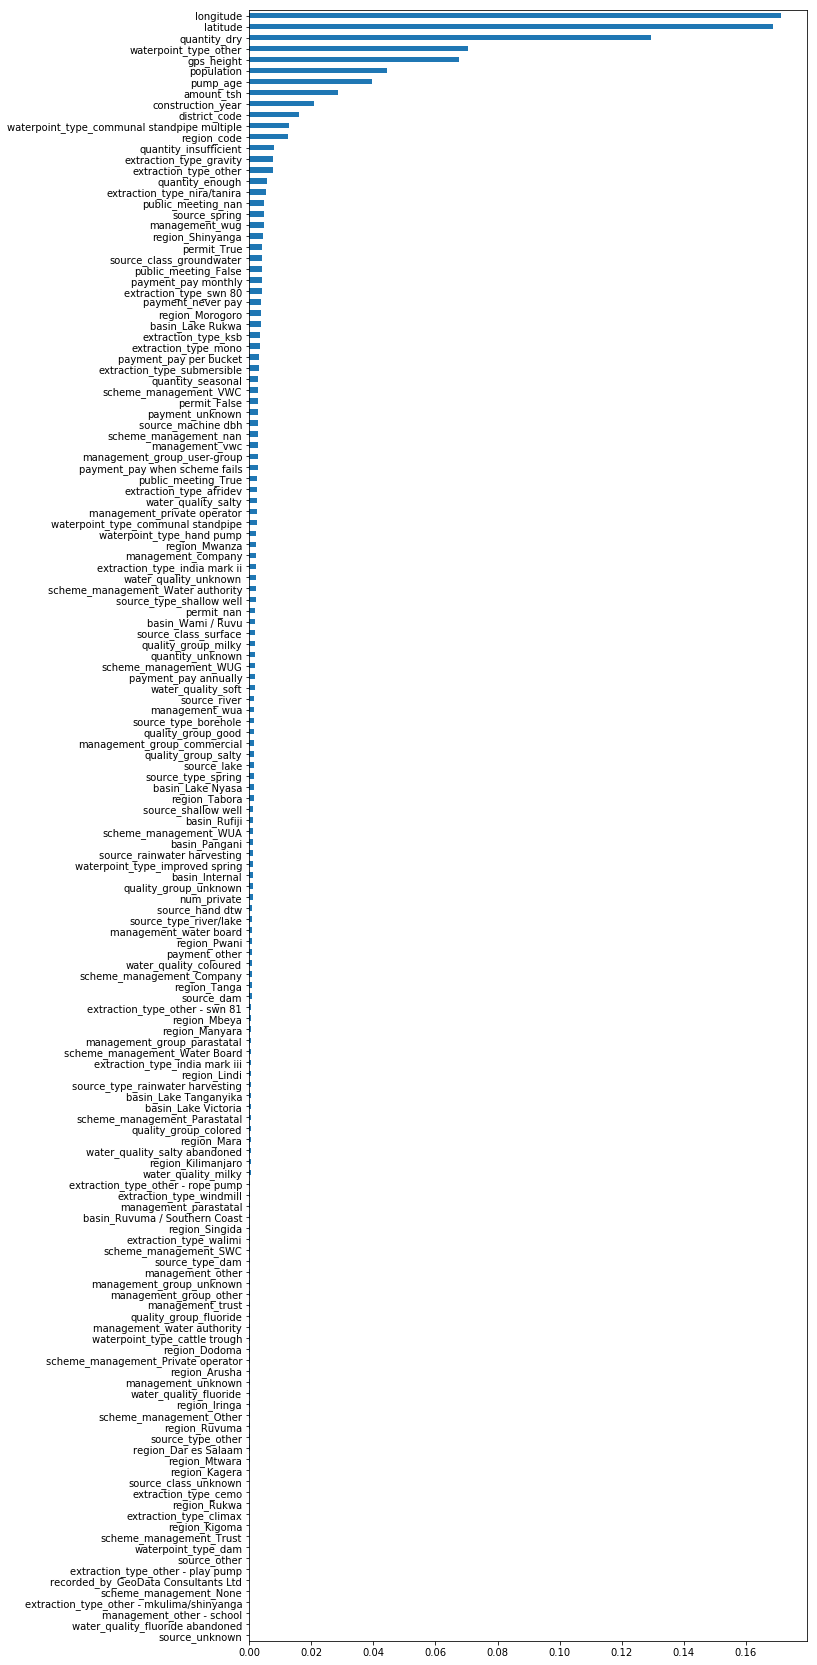

In [78]:
%matplotlib inline
import matplotlib.pyplot as plt
encoder = decision_tree.named_steps['onehotencoder']
encoded_columns = encoder.fit_transform(X_train).columns
importances = pd.Series(model.feature_importances_, encoded_columns)
plt.figure(figsize=(10,30))
importances.sort_values().plot.barh();

In [87]:
sorted(X_train.pump_age.unique())

[nan,
 -7.0,
 -5.0,
 -4.0,
 -3.0,
 -2.0,
 -1.0,
 0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 20.0,
 21.0,
 22.0,
 23.0,
 24.0,
 25.0,
 26.0,
 27.0,
 28.0,
 29.0,
 30.0,
 31.0,
 32.0,
 33.0,
 34.0,
 35.0,
 36.0,
 37.0,
 38.0,
 39.0,
 40.0,
 41.0,
 42.0,
 43.0,
 44.0,
 45.0,
 46.0,
 47.0,
 48.0,
 49.0,
 50.0,
 51.0,
 52.0,
 53.0]

In [90]:
train.query('pump_age < 0')

,id,amount_tsh,date_recorded,funder,gps_height,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,management,management_group,payment,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,status_group,pump_age
27501,53086,500.0,2004-01-07,Kkkt,1611,34.900561,-8.873813,Kwa Barnabasi Kilumile,0,Rufiji,Mlowa,Iringa,11,4.0,Njombe,Makambako,65,True,GeoData Consultants Ltd,VWC,NaN,False,2009.0,nira/tanira,vwc,user-group,pay when scheme fails,soft,good,enough,hand dtw,borehole,groundwater,hand pump,functional,-5.0
39559,15921,0.0,2004-03-06,Tasafu,301,38.558421,-5.140405,Shuleni,0,Pangani,Kiwanjani,Tanga,4,2.0,Korogwe,Kwagunda,713,True,GeoData Consultants Ltd,VWC,NaN,False,2009.0,other,vwc,user-group,never pay,soft,good,dry,shallow well,shallow well,groundwater,other,non functional,-5.0
8729,20198,0.0,2004-05-01,Government Of Tanzania,86,38.959776,-5.247278,Kwa Bi Shoga,0,Pangani,Mapojoni Kati,Tanga,4,4.0,Muheza,Ngomeni,120,True,GeoData Consultants Ltd,VWC,Borehole,True,2008.0,india mark ii,vwc,user-group,never pay,salty abandoned,salty,dry,shallow well,shallow well,groundwater,hand pump,non functional,-4.0
33942,5971,0.0,2004-03-01,Amref,-27,39.283105,-7.422852,Kwa Ndevu,0,Rufiji,Gundani,Pwani,6,4.0,Mkuranga,Magawa,200,True,GeoData Consultants Ltd,VWC,NaN,False,2007.0,swn 80,vwc,user-group,never pay,soft,good,seasonal,shallow well,shallow well,groundwater,hand pump,non functional,-3.0
23373,20534,50.0,2004-03-01,Tasaf And Lga,239,39.272736,-11.019000,Juhudi,0,Ruvuma / Southern Coast,Mwanona,Mtwara,90,33.0,Newala,Luchingu,317,True,GeoData Consultants Ltd,VWC,Mwanona,False,2009.0,gravity,vwc,user-group,pay per bucket,soft,good,enough,spring,spring,groundwater,communal standpipe multiple,functional,-5.0
13366,48759,100.0,2004-06-01,Mgaya,1331,34.290885,-1.699609,Maro Mgaya,0,Lake Victoria,Kibaoni,Mara,20,2.0,Serengeti,Kenyamonta,80,NaN,GeoData Consultants Ltd,Other,NaN,True,2011.0,other - rope pump,other,other,pay per bucket,soft,good,enough,shallow well,shallow well,groundwater,hand pump,functional,-7.0
48555,1251,0.0,2004-12-01,African 2000 Network,284,38.929212,-7.111349,Kauzeni Primary School 2,0,Wami / Ruvu,Kauzeni Chini,Pwani,60,33.0,Kisarawe,Kibuta,185,True,GeoData Consultants Ltd,Private operator,NaN,False,2008.0,gravity,private operator,commercial,never pay,soft,good,enough,rainwater harvesting,rainwater harvesting,surface,communal standpipe,functional,-4.0
10441,55069,20.0,2004-12-01,Plan Int,307,38.768656,-7.298419,Mianzi Primary School,0,Rufiji,Momboni,Pwani,60,33.0,Kisarawe,Msanga,1,True,GeoData Consultants Ltd,VWC,NaN,False,2006.0,india mark iii,vwc,user-group,pay per bucket,soft,good,enough,spring,spring,groundwater,hand pump,non functional,-2.0
32619,9195,0.0,2004-03-01,Caltus,1856,31.539761,-7.983106,Kwa Pambajila,0,Lake Tanganyika,Magomeni,Rukwa,15,4.0,Sumbawanga Urban,Kasense,900,True,GeoData Consultants Ltd,VWC,Mradi wa maji wa kasen,True,2005.0,gravity,vwc,user-group,never pay,soft,good,dry,spring,spring,groundwater,communal standpipe,non functional,-1.0


In [97]:
X_train.waterpoint_type.value_counts(dropna=False)

communal standpipe             22778
hand pump                      14015
other                           5138
communal standpipe multiple     4864
improved spring                  631
cattle trough                     89
dam                                5
Name: waterpoint_type, dtype: int64

In [98]:
X_train.gps_height.value_counts(dropna=False)

 0       16305
-15         48
 1290       45
-20         43
-14         43
-16         42
-13         42
-18         40
 280        39
 1269       37
 320        37
 1304       37
 1538       37
 303        36
 1295       36
 1303       36
 1264       36
-8          36
 338        36
 1286       36
 1359       35
 1342       35
 1240       35
 1613       35
 1335       35
 1319       35
 1602       35
 1401       35
 1288       35
-27         34
         ...  
 2292        1
 2388        1
 2420        1
 2484        1
 2295        1
 2417        1
 2385        1
 2353        1
 2319        1
 2285        1
 2413        1
 2509        1
 2220        1
 621         1
 653         1
 2159        1
 2255        1
 2287        1
 2351        1
 2321        1
 622         1
 1998        1
 2126        1
 2254        1
 2286        1
 2318        1
 591         1
 2193        1
 2289        1
 2031        1
Name: gps_height, Length: 2401, dtype: int64

## Assignment
- [ ] Do train/validate/test split with the Tanzania Waterpumps data.
- [ ] Define a function to wrangle train, validate, and test sets in the same way. Clean outliers and engineer features. (For example, [what other columns have zeros and shouldn't?](https://github.com/Quartz/bad-data-guide#zeros-replace-missing-values) What other columns are duplicates, or nearly duplicates? Can you extract the year from date_recorded? Can you engineer new features, such as the number of years from waterpump construction to waterpump inspection?)
- [ ] Select features. Use a scikit-learn pipeline to encode categoricals, impute missing values, and fit a decision tree classifier.
- [ ] Get your validation accuracy score.
- [ ] Get and plot your feature importances.
- [ ] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [ ] Commit your notebook to your fork of the GitHub repo.


**Submit your predictions to our Kaggle competition.**

In [0]:
test_pred = decision_tree.predict(X_test)
submission = sample_submission.copy()
submission['status_group'] = test_pred
submission.to_csv('submission-02.csv', index=False)